In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install joblib==1.2.0

  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [4]:
# set project folder directory
DATA_DIR = '../data'

In [5]:
# load some lib
import os
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import joblib

# import some modeling libraries
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 # Load in based ResNet50 model
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA


# read in metadata
df_meta = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_Metadata.csv", index_col = 0)
df_meta

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [12]:
# read in summary of data set
df_data_summary = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_dataset_Summary.csv", index_col = 0)
df_data_summary['Label_2_Virus_category'] = np.where((df_data_summary['Label'] == 'Normal'), 
                                              'Normal',
                                              np.where(
                                                  (df_data_summary['Label_2_Virus_category'] != df_data_summary['Label_2_Virus_category']) & 
                                                  ~(df_data_summary['Label_1_Virus_category'] != df_data_summary['Label_1_Virus_category']),
                                                  df_data_summary['Label_1_Virus_category'],
                                                  df_data_summary['Label_2_Virus_category']
                                              ))

df_data_summary['Label_1_Virus_category'] = np.where((df_data_summary['Label'] == 'Normal'), 
                                              'Normal', 
                                              df_data_summary['Label_1_Virus_category']
                                              )

df_data_summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,Normal,Normal,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,Virus,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,bacteria,2772
6,Pnemonia,bacteria,Streptococcus,5


In [13]:
# creating data label map
df_data_summary = df_data_summary[df_data_summary['Label_1_Virus_category'] != 'Stress-Smoking']
label_map = df_data_summary[['Label_1_Virus_category']].drop_duplicates().reset_index(drop=True).to_dict()['Label_1_Virus_category']
label_map = { val.lower(): key for key, val in label_map.items()}
label_map

{'normal': 0, 'virus': 1, 'bacteria': 2}

# Image Visualization
Read in some image to show some visualization

In [ ]:
# load image data
def grab_one_and_plot(df, col_category, data_set = 'train'):
  """
    For data visualization, grab each image from the specified column directory
    Show the image
  """
  # copy the meta; avoid mutation
  df_copy = df.copy()


  # instantitae canvas for plotting
  plt.figure(figsize=(15,5))

  for i, cat in enumerate(df_copy[col_category].unique()):

      print(cat)

      # locate the image and build path to the image
      img_meta = df_copy[df_copy[col_category] == cat].iloc[153]
      train_test = data_set
      path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"


      # grab the image path and plot
      img = Image.open(path)
      plt.subplot(1, len(df_copy[col_category].unique()), i+1)
      plt.imshow(img, cmap='gray')
      plt.axis('off')
      plt.title(f"{train_test}: {cat} Chest X-ray")
      
      
  plt.show()

# grab_one_and_plot(df_meta, "Label")


## Image Resizing

Interesting, the X-ray images are not of even size. Here we want to resize each image to (224 x 224) because images of even dimension are easier to model.



In [8]:

# def resize_image(image):
#     """
#         Resize Image to fit VGG16 Imagenet input dimension
#         dim = (224 x 224 x 3)
#     """
#     width, height = image.size
#     if width > height:
#         left = (width - height) / 2
#         right = width - left
#         top = 0
#         bottom = height
#     else:
#         top = (height - width) / 2
#         bottom = height - top
#         left = 0
#         right = width
#     image = image.crop((left, top, right, bottom))
#     image = image.resize([224, 224], Image.LANCZOS)
#     return image


# def main(path_in, path_out):
#     """
#       Function to initiate the resizing process
#     """
#     if not os.path.exists(path_out):
#         os.makedirs(path_out)

#     print('Start resizing images.')
#     image_files = os.listdir(path_in)
#     num_images = len(image_files)
#     for i, image_file in tqdm(enumerate(image_files)):
#         with open(os.path.join(path_in, image_file), 'r+b') as f:
#             with Image.open(f) as image:
#                 image = resize_image(image)
#                 image.save(os.path.join(path_out, image_file), image.format)


# path_in = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
# path_out = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_resized'
# main(path_in, path_out)

In [9]:
# grab_one_and_plot(df_meta, "Label", "train_resized")

# Simple Model

1. pre-process the image to grab the label per image
2. do a simple model with multiple labels

In [14]:
df_meta = df_meta[df_meta['Label_1_Virus_category'] != 'Stress-Smoking']

In [15]:
df_meta['Label_1_Virus_category'].unique()

array([nan, 'Virus', 'bacteria'], dtype=object)

In [16]:
# fill some label nan
# certain bacteria/virus does not have a distinct label, for these we will be using the regular virus/barteria term
# in case of normal, we will label it as nomal
df_meta['Label_2_Virus_category'] = np.where((df_meta['Label'] == 'Normal'), 
                                              'Normal',
                                              np.where(
                                                  (df_meta['Label_2_Virus_category'] != df_meta['Label_2_Virus_category']) & 
                                                  ~(df_meta['Label_1_Virus_category'] != df_meta['Label_1_Virus_category']),
                                                  df_meta['Label_1_Virus_category'],
                                                  df_meta['Label_2_Virus_category']
                                              ))


df_meta['Label_1_Virus_category'] = np.where((df_meta['Label'] == 'Normal'), 
                                              'Normal',
                                              df_meta['Label_1_Virus_category'])

# select and rename meta dataset columns
df_meta = df_meta[['Dataset_type', 'X_ray_image_name', 'Label_1_Virus_category']]
df_meta['Label_1_Virus_category'] = df_meta['Label_1_Virus_category'].str.lower()
df_meta['label'] = df_meta['Label_1_Virus_category'].map(label_map)


# get a list of unique labels to train from
label_list = sorted(list(df_meta['label'].unique()))
print(label_list)

# get train data
df_train = df_meta[df_meta['Dataset_type'] == 'TRAIN']
df_train

[0, 1, 2]


C:\Users\ktrin\AppData\Local\Temp\ipykernel_20004\1181464370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta['Label_2_Virus_category'] = np.where((df_meta['Label'] == 'Normal'),
C:\Users\ktrin\AppData\Local\Temp\ipykernel_20004\1181464370.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta['Label_1_Virus_category'] = np.where((df_meta['Label'] == 'Normal'),
C:\Users\ktrin\AppData\Local\Temp\ipykernel_20004\1181464370.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,Dataset_type,X_ray_image_name,Label_1_Virus_category,label
0,TRAIN,IM-0128-0001.jpeg,normal,0
1,TRAIN,IM-0127-0001.jpeg,normal,0
2,TRAIN,IM-0125-0001.jpeg,normal,0
3,TRAIN,IM-0122-0001.jpeg,normal,0
4,TRAIN,IM-0119-0001.jpeg,normal,0
...,...,...,...,...
5304,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,virus,1
5305,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,virus,1
5306,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,virus,1
5307,TRAIN,1-s2.0-S0140673620303706-fx1_lrg.jpg,virus,1


In [13]:
# get test data
df_test = df_meta[df_meta['Dataset_type'] == 'TEST']
df_test

,Dataset_type,X_ray_image_name,Label_1_Virus_category,label
5309,TEST,IM-0021-0001.jpeg,normal,0
5310,TEST,IM-0019-0001.jpeg,normal,0
5311,TEST,IM-0017-0001.jpeg,normal,0
5312,TEST,IM-0016-0001.jpeg,normal,0
5313,TEST,IM-0015-0001.jpeg,normal,0
...,...,...,...,...
5928,TEST,person1637_virus_2834.jpeg,virus,1
5929,TEST,person1635_virus_2831.jpeg,virus,1
5930,TEST,person1634_virus_2830.jpeg,virus,1
5931,TEST,person1633_virus_2829.jpeg,virus,1


In [14]:
df_train['IMG'] = df_train['X_ray_image_name'].str.split(".").str[0]
df_test['IMG'] = df_test['X_ray_image_name'].str.split(".").str[0]

C:\Users\ktrin\AppData\Local\Temp\ipykernel_21620\654978615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['IMG'] = df_train['X_ray_image_name'].str.split(".").str[0]
C:\Users\ktrin\AppData\Local\Temp\ipykernel_21620\654978615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['IMG'] = df_test['X_ray_image_name'].str.split(".").str[0]


In [15]:
df_train

,Dataset_type,X_ray_image_name,Label_1_Virus_category,label,IMG
0,TRAIN,IM-0128-0001.jpeg,normal,0,IM-0128-0001
1,TRAIN,IM-0127-0001.jpeg,normal,0,IM-0127-0001
2,TRAIN,IM-0125-0001.jpeg,normal,0,IM-0125-0001
3,TRAIN,IM-0122-0001.jpeg,normal,0,IM-0122-0001
4,TRAIN,IM-0119-0001.jpeg,normal,0,IM-0119-0001
...,...,...,...,...,...
5304,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,virus,1,1-s2
5305,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,virus,1,1-s2
5306,TRAIN,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,virus,1,1-s2
5307,TRAIN,1-s2.0-S0140673620303706-fx1_lrg.jpg,virus,1,1-s2


In [16]:
import pickle
sift_features_train = pickle.load(open(f"{DATA_DIR}/processed/sift_features.pkl", "rb"))
sift_features_test = pickle.load(open(f"{DATA_DIR}/processed/sift_features_test.pkl", "rb"))

In [19]:
# build a list of training data
data_path = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train_resized_augmented'

train_image_data = {"img": [], "sift": []}
train_label = []

for key, sift_desc in tqdm(sift_features_train.items()):

    # remove unwanted charaters
    img_name_list = key.split("_")[1: -2]
    img_name = "_".join(img_name_list)

    label = df_train[df_train['IMG'] == img_name]['label'].values
    # ignore image that have low number of SIFT keypoint descriptions
    # here we decide to grab a threshold of 100 to: 
    # 1. keep training size large 
    # 2. keep a lower computation power
    # ignore faulty image nameing
    if (sift_desc.shape[0] < 100) or len(label) != 1:
      continue
    
    path = f"{data_path}/{key}"
    img = Image.open(path)
    img = img.convert("RGB")

    desc = sift_desc[:100,:].flatten()

    train_image_data['img'].append(np.array(img))
    train_image_data['sift'].append(np.array(desc))
    train_label.append(label[0])

  0%|          | 0/21649 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train_resized_augmented/augmented_streptococcus-pneumoniae-pneumonia-1_0_258.jpeg'

In [20]:
# build a list of training data
data_path = f'{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_resized_augmented'

test_image_data = {"img": [], "sift": []}
test_label = []

for key, sift_desc in tqdm(sift_features_test.items()):

    # remove unwanted charaters
    img_name_list = key.split("_")[1: -2]
    img_name = "_".join(img_name_list)
    label = df_test[df_test['IMG'] == img_name]['label'].values

    # ignore image that have low number of SIFT keypoint descriptions
    # here we decide to grab a threshold of 100 to: 
    # 1. keep training size large 
    # 2. keep a lower computation power
    # ignore faulty image nameing
    if (sift_desc.shape[0] < 100) or len(label) != 1:
      continue
    
    path = f"{data_path}/{key}"
    img = Image.open(path)
    img = img.convert("RGB")

    desc = sift_desc[:100,:].flatten()

    test_image_data['img'].append(np.array(img))
    test_image_data['sift'].append(np.array(desc))
    test_label.append(label[0])

  0%|          | 0/3119 [00:00<?, ?it/s]

In [21]:
train_image_data['img'] = np.array(train_image_data['img'])
train_image_data['sift'] = np.array(train_image_data['sift'])

In [22]:
test_image_data['img'] = np.array(test_image_data['img'])
test_image_data['sift'] = np.array(test_image_data['sift'])

In [23]:
train_label = np.array(train_label)
train_label[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [24]:
test_label = np.array(test_label)
# test_label = [l[0] for l in test_label]
test_label[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [25]:
# # save on data loading by pickling the dataset
# # output the dataset as a pickle so we don't have to load it everytime
joblib.dump(train_image_data, f"{DATA_DIR}/processed/image_data_aug.gz", compress='gzip')  
joblib.dump(train_label, f"{DATA_DIR}/processed/image_caption_data_aug.gz", compress='gzip')  

['../data/processed/image_caption_data_aug.gz']

In [26]:
# # save on data loading by pickling the dataset
# # output the dataset as a pickle so we don't have to load it everytime
joblib.dump(test_image_data, f"{DATA_DIR}/processed/test_image_data_aug.gz", compress='gzip')  
joblib.dump(test_label, f"{DATA_DIR}/processed/test_image_caption_data_aug.gz", compress='gzip')  

['../data/processed/test_image_caption_data_aug.gz']

In [6]:
# joblib load
train_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/image_data_aug.gz", 'rb') )
train_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/image_caption_data_aug.gz", 'rb') )

# loading test set
test_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/test_image_data_aug.gz", 'rb') )
test_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/test_image_caption_data_aug.gz", 'rb') )

In [7]:
# compute PCA on the SIFT features
# applying PCA components = 20 from earlier analysis
pca=PCA(n_components=20) 
train_image_data_sift = pca.fit_transform(train_image_data['sift'])

# applying the same transformation on the test image data
test_image_data_sift=pca.transform(test_image_data['sift'])

In [8]:
# load in the base model
# freeze all the weights (avoid overfitting)
cnn_model = ResNet50(input_shape = (224, 224, 3),    # Shape of our images
                    include_top = False,           # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in cnn_model.layers:
    layer.trainable = False
cnn_model.layers

In [ ]:
# image normalization
train_image_data['img'] = train_image_data['img'].astype('float64')
test_image_data['img'] = test_image_data['img'].astype('float64')
train_image_data['img'] = train_image_data['img'] / 224
test_image_data['img'] = test_image_data['img'] / 224

In [19]:
def image_label_fine_tuning(image_shape=(224, 224, 3),
                            encoder_model=cnn_model,
                            hidden_dimensions=[256, 128],
                            dropout_rate=0.3,
                            label_list = []):
    """
        Image captioning model architecture:
            1. ImageNet pretrained CNN model to encode a given image
            2. decoder takes in the CNN image hidden state and run through LSTM
    """

    # Encoder architecture: take in source image, feed through CNN, catch the last pooled pooled layer
    # create the context vecto
    source_image = keras.layers.Input(shape=image_shape, dtype='float64', name='source_image_layer')
    cnn_model_layer = keras.Model(inputs=encoder_model.input, outputs=encoder_model.layers[-1].output)
    source_image_encoding = cnn_model_layer(source_image)
    source_image_encoding = keras.layers.GlobalAveragePooling2D()(source_image_encoding)
    cnn_hidden_output = keras.layers.Dense(512, activation='relu', name='cnn_hidden_layer')(source_image_encoding)

    last_hidden_output = cnn_hidden_output
    
    # add a fully connected feed-forward net (because why not lol)
    # some final dropout layer
    # add final classification layer
    for hidden_layer_size in hidden_dimensions:
        last_hidden_output = keras.layers.Dense(hidden_layer_size, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)


    output = keras.layers.Dense(len(label_list), activation='softmax', name="output_layer")(last_hidden_output)

    # instantiate and compile the model
    model = keras.Model(inputs=source_image, outputs=output)
    model.compile(optimizer='Adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    return model


In [20]:
img_classification_model = image_label_fine_tuning(label_list = label_list)
img_classification_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_image_layer (InputLa  [(None, 224, 224, 3)]    0         
 yer)                                                            
                                                                 
 model_1 (Functional)        (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 cnn_hidden_layer (Dense)    (None, 100)               204900    
                                                                 
 dense_2 (Dense)             (None, 256)               25856     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0   

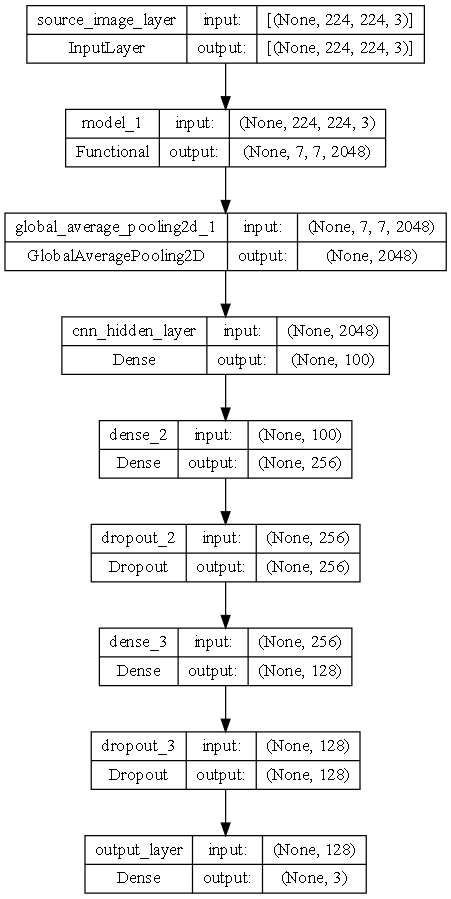

In [21]:
keras.utils.plot_model(img_classification_model, show_shapes=True, dpi=90)

In [25]:
img_classification_model.fit(x=train_image_data['img'],
                            y=train_label,
                            validation_split=0.1,
                            batch_size=32,
                            epochs=15)

Epoch 1/15
552/552 [==============================] - 1202s 2s/step - loss: 0.8937 - accuracy: 0.5847 - val_loss: 0.9991 - val_accuracy: 0.5056
Epoch 2/15
552/552 [==============================] - 1175s 2s/step - loss: 0.7749 - accuracy: 0.6577 - val_loss: 0.9128 - val_accuracy: 0.5647
Epoch 3/15
552/552 [==============================] - 1164s 2s/step - loss: 0.7448 - accuracy: 0.6730 - val_loss: 0.9516 - val_accuracy: 0.5362
Epoch 4/15
552/552 [==============================] - 1165s 2s/step - loss: 0.7260 - accuracy: 0.6791 - val_loss: 0.9850 - val_accuracy: 0.5301
Epoch 5/15
552/552 [==============================] - 1166s 2s/step - loss: 0.6957 - accuracy: 0.6916 - val_loss: 0.9066 - val_accuracy: 0.5540
Epoch 6/15
552/552 [==============================] - 1165s 2s/step - loss: 0.6979 - accuracy: 0.6903 - val_loss: 0.8907 - val_accuracy: 0.5642
Epoch 7/15
552/552 [==============================] - 1166s 2s/step - loss: 0.6859 - accuracy: 0.6928 - val_loss: 0.7976 - val_accuracy:

In [26]:
# save model
img_classification_model.save(f"{DATA_DIR}/outputs/pneumonia_base_cnn_model_augmented_lstm_resNet50.h5")

In [27]:
# load the model
img_classification_model = keras.models.load_model(f"{DATA_DIR}/outputs/pneumonia_base_cnn_model_augmented_lstm_resNet50.h5")

In [29]:
y_pred = np.argmax(img_classification_model.predict(test_image_data['img']), axis=-1)
y_pred

94/94 [==============================] - 179s 2s/step


array([2, 0, 0, ..., 2, 2, 2], dtype=int64)

Text(0.5, 1.0, 'ResNet Confusion Matrix')

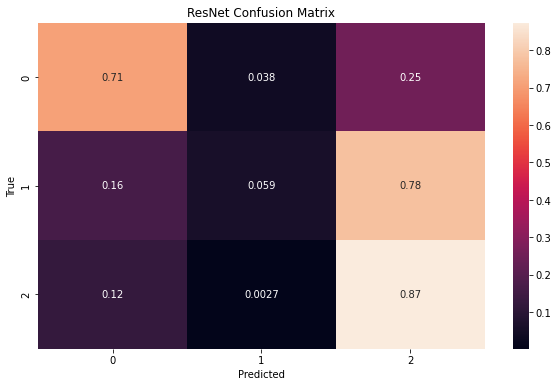

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet Confusion Matrix")

In [33]:
from sklearn.metrics import classification_report
print(classification_report(test_label, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1168
           1       0.47      0.06      0.10       712
           2       0.53      0.87      0.66      1097

    accuracy                           0.61      2977
   macro avg       0.59      0.55      0.50      2977
weighted avg       0.61      0.61      0.56      2977



# Graveyard

In [ ]:
def image_label_fine_tuning(image_shape=(224, 224, 3),
                            encoder_model=cnn_model,
                            hidden_dimensions=[256, 128],
                            dropout_rate=0.3,
                            label_list = []):
    """
        Image captioning model architecture:
            1. ImageNet pretrained CNN model to encode a given image
            2. decoder takes in the CNN image hidden state and run through LSTM
    """

    # Encoder architecture: take in source image, feed through CNN, catch the last pooled pooled layer
    # create the context vecto
    source_image = keras.layers.Input(shape=image_shape, dtype='float64', name='source_image_layer')
    cnn_model_layer = keras.Model(inputs=encoder_model.input, outputs=encoder_model.layers[-1].output)
    source_image_encoding = cnn_model_layer(source_image)
    source_image_encoding = keras.layers.GlobalAveragePooling2D()(source_image_encoding)
    cnn_hidden_output = keras.layers.Dense(512, activation='relu', name='cnn_hidden_layer')(source_image_encoding)

    last_hidden_output = cnn_hidden_output
    # print(cnn_hidden_output.shape)
    # # annotaion_vector = keras.layers.Concatenate(axis=-1)([source_image_encoding])


    # adding SIFT features
    sift_features = keras.layers.Input(shape=(20,), dtype='float64', name='sift_feature_layer')

    embedding_layer = keras.layers.Embedding(input_dim=20,
                                                output_dim=100,
                                                name='caption_embedding_layer')
    embed_caption = embedding_layer(sift_features)

    lstm_layer = keras.layers.LSTM(100, return_sequences=True, return_state=True, name="decoder_lstm_layer")
    decoder_output, decoder_state_h_output, decoder_state_c_output = lstm_layer(embed_caption, initial_state=[cnn_hidden_output, cnn_hidden_output])

    last_hidden_output = decoder_output
    
    # add a fully connected feed-forward net (because why not lol)
    # some final dropout layer
    # add final classification layer
    for hidden_layer_size in hidden_dimensions:
        last_hidden_output = keras.layers.Dense(hidden_layer_size, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    # last_hidden_output =  keras.layers.GlobalAveragePooling1D()(last_hidden_output)


    output = keras.layers.Dense(len(label_list), activation='softmax', name="output_layer")(last_hidden_output)

    # instantiate and compile the model
    model = keras.Model(inputs=source_image, outputs=output)
    model.compile(optimizer='Adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    return model
